In [1]:
import numpy as np
import sys
import os

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))
import signalConditioning
import visualization
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense,LSTM, Dropout, Bidirectional,Input, Conv1D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SimpleRNN,BatchNormalization, TimeDistributed
from tensorflow.keras.datasets import reuters

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.callbacks import EarlyStopping



from sklearn.model_selection import train_test_split
import h5py



In [2]:
hf = h5py.File("../../Datasets/data.hdf5", 'r')
features = np.array(hf.get("features"))
erp_labels = np.array(hf.get("erp_labels"))
codes = np.array(hf.get("codes"))
trials = np.array(hf.get("trials"))
sequences = np.array(hf.get("sequences"))
matrix_indexes = np.array(hf.get("matrix_indexes"))
run_indexes = np.array(hf.get("run_indexes"))
subjects = np.array(hf.get("subjects"))
database_ids = np.array(hf.get("database_ids"))
target = np.array(hf.get("target"))
matrix_dims = np.array(hf.get("matrix_dims"))
hf.close()

In [210]:
features.shape

(701615, 128, 8)

In [212]:
erp_labels[0:100]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [3]:
y = erp_labels
X = features

In [3]:
#We load in the Raw EEG Signals
path = "../../Data"
files = os.listdir(path)

raw_signals = []
labels = [] 

for file in files:
     
     
    if file == "Labels":
        continue
     
    raw_signals.append(np.load(f"{path}/{file}"))    
    print(file)

labels_path = path + "/Labels"
print(labels_path)
print(os.listdir(labels_path))

for file in os.listdir(labels_path):
    print(file)
    labels.append(np.load(f"{labels_path}/{file}",allow_pickle=True))
    
preprocessing_steps = [raw_signals]

sub-9_ses-0.npy
sub-4_ses-3.npy
sub-2_ses-12.npy
sub-2_ses-4.npy
sub-11_ses-14.npy
sub-2_ses-5.npy
sub-2_ses-13.npy
sub-4_ses-2.npy
sub-9_ses-1.npy
sub-9_ses-3.npy
sub-4_ses-0.npy
sub-2_ses-11.npy
sub-7_ses-8.npy
sub-2_ses-7.npy
sub-7_ses-14.npy
sub-2_ses-6.npy
sub-7_ses-9.npy
sub-2_ses-10.npy
sub-4_ses-1.npy
sub-9_ses-2.npy
sub-9_ses-6.npy
sub-4_ses-5.npy
sub-2_ses-14.npy
sub-2_ses-2.npy
sub-11_ses-13.npy
sub-7_ses-11.npy
sub-7_ses-10.npy
sub-11_ses-12.npy
sub-2_ses-3.npy
sub-4_ses-4.npy
sub-9_ses-7.npy
sub-9_ses-5.npy
sub-4_ses-6.npy
sub-11_ses-8.npy
sub-2_ses-1.npy
sub-1_ses-9.npy
sub-11_ses-10.npy
sub-7_ses-12.npy
sub-7_ses-13.npy
sub-11_ses-11.npy
sub-1_ses-8.npy
sub-2_ses-0.npy
sub-11_ses-9.npy
sub-4_ses-7.npy
sub-9_ses-4.npy
sub-3_ses-4.npy
sub-8_ses-0.npy
sub-5_ses-3.npy
sub-8_ses-14.npy
sub-3_ses-20.npy
sub-5_ses-2.npy
sub-8_ses-1.npy
sub-3_ses-5.npy
sub-3_ses-7.npy
sub-8_ses-3.npy
sub-5_ses-0.npy
sub-6_ses-8.npy
sub-6_ses-9.npy
sub-5_ses-1.npy
sub-8_ses-2.npy
sub-5_ses-14.npy

In [5]:
print(len(raw_signals))

print(len(labels))

171
171


In [15]:
X[0].T[0].shape

(128,)

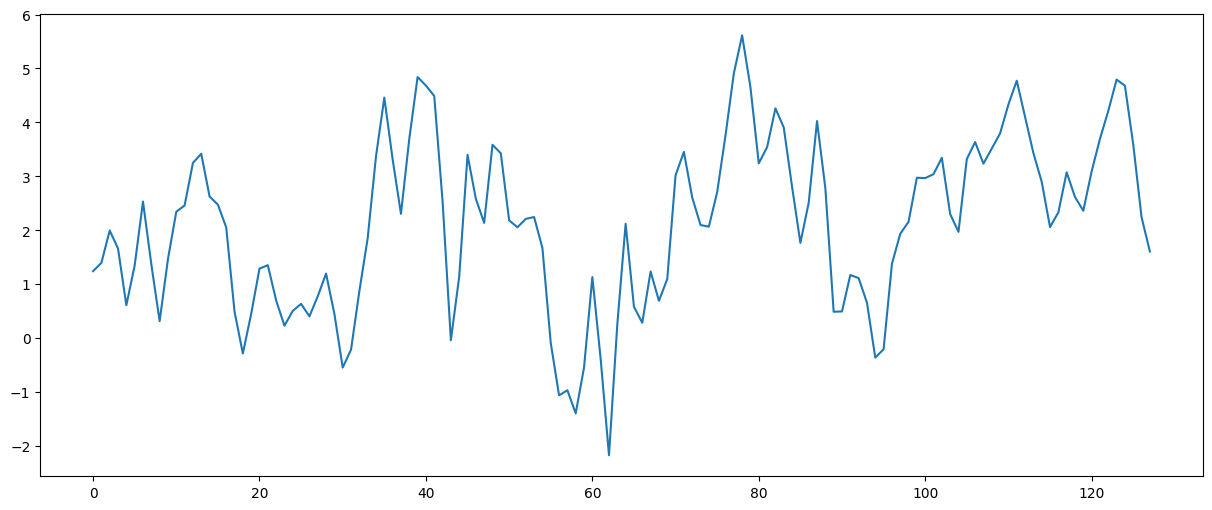

In [4]:
visualization.plotEEG(X[0].T[0],(15,6))

##### **We will now start with the cleaning process of the signals, starting by applying a passband filter to remove unwanted frequencies** #####

In [4]:
data = [x for x in raw_signals]


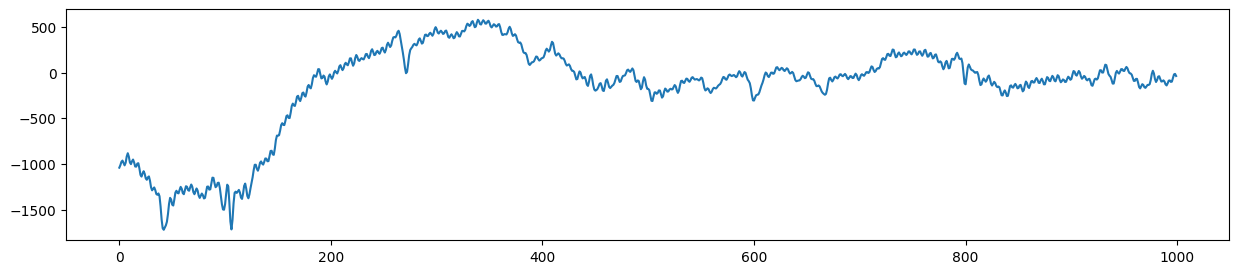

In [5]:
#Since the bandpass function only filters one EEG signal, we will loop through all out EEG Signals, and filter them accordingly

#We will iterate each of our signals, and apply the filters for each one 

data = [signalConditioning.bandPassFilter(x,fs=250) for x in raw_signals]

preprocessing_steps.append(data)


visualization.plotEEG(data[0][0][1000:2000],(15,3))

##### **Now that we've applied the bandpass filter we will now apply a notch filter to remove the interferences from the electricity** #####

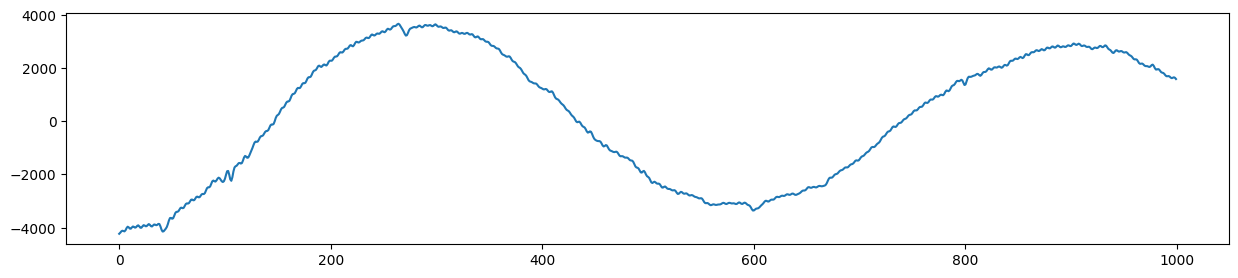

In [6]:
data = [signalConditioning.notchFilter(x,250) for x in data]
preprocessing_steps.append(data)
visualization.plotEEG(data[0][0][1000:2000],(15,3))

##### **Now we will apply mean referencing to remove the common noise in between each of the channels** ######

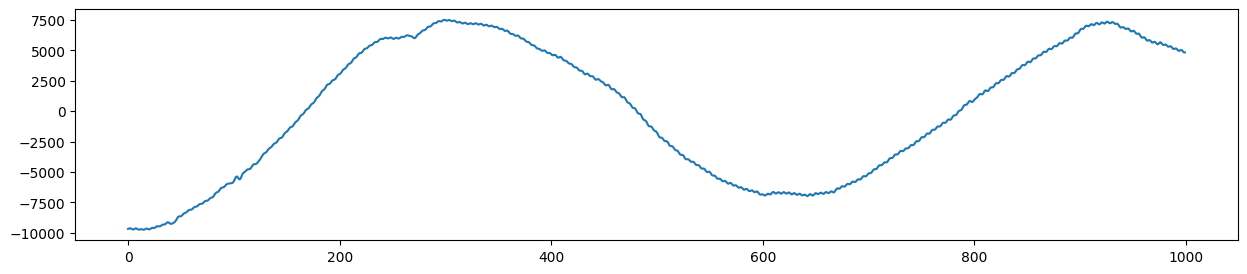

In [7]:
data = [signalConditioning.mean_referencing(x) for x in data]
preprocessing_steps.append(data)
visualization.plotEEG(data[0][0][1000:2000],(15,3))

##### **We will now scale the signal so that the time series can be comparable** ####

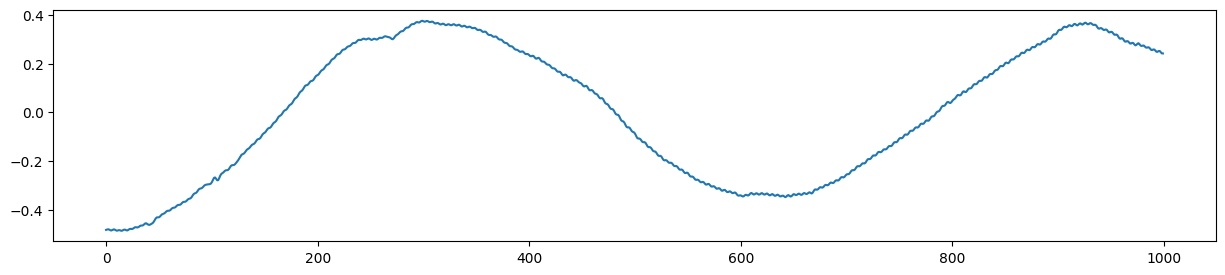

In [8]:
data = [signalConditioning.scale_signal(x) for x in data]
preprocessing_steps.append(data)
visualization.plotEEG(data[0][0][1000:2000],(15,3))

#### **Now we will normalize the signal so that the models and more complex methods can learn better** ####

In [9]:
# data = [signalConditioning.normalize(x) for x in data]
# preprocessing_steps.append(data)
# visualization.plotEEG(data[1][0][0:1000],(15,3))

In [10]:
# # np.stack(preprocessing_steps)
# preprocessing_steps_final = []

# for i in range(len(preprocessing_steps[0])):
#     currSig = []    
#     for j in range(len(preprocessing_steps)):
#         currSig.append(preprocessing_steps[j][i])
        
#     preprocessing_steps_final.append(currSig)
        

In [11]:
# for i in range(len(preprocessing_steps_final)):
#     for j in range(len(preprocessing_steps_final[i])):
#         preprocessing_steps_final[i][j] = np.mean(preprocessing_steps_final[i][j],axis=0)
#         preprocessing_steps_final[i][j] =preprocessing_steps_final[i][j][0:1000]





In [12]:
# preprocessing_steps_final[0].reverse()
# visualization.plotEEG(np.stack(preprocessing_steps_final[0]),(15,3))

#### Now that our signals are relatievly clean we will start Applying ICA and visualizing the results ####

Removed components: [0, 2, 6, 7] / 8
Removed components: [0, 1, 4, 5, 6, 7] / 8
Removed components: [0, 1, 2, 3, 4, 5, 6, 7] / 8
Removed components: [1, 3, 4, 5, 6] / 8
Removed components: [1, 3, 4, 6] / 8
Removed components: [0, 1, 3, 6] / 8
Removed components: [0, 1, 4, 6] / 8
Removed components: [0, 1, 2, 4, 5, 6, 7] / 8
Removed components: [1, 2, 3, 6, 7] / 8
Removed components: [0, 1, 3, 4, 5, 6] / 8
Removed components: [1, 2, 4, 5, 6, 7] / 8
Removed components: [1, 3, 4, 5, 6] / 8
Removed components: [0, 2, 4, 5, 6, 7] / 8
Removed components: [] / 8
Removed components: [0, 5, 6] / 8
Removed components: [0, 1, 2, 3, 5] / 8
Removed components: [2, 3, 4, 5, 7] / 8
Removed components: [1, 3, 4, 5] / 8
Removed components: [2, 5, 6, 7] / 8
Removed components: [1, 2, 3, 5] / 8
Removed components: [2, 3, 4, 6, 7] / 8
Removed components: [2, 3, 5, 6, 7] / 8
Removed components: [0, 1, 2, 4, 6] / 8
Removed components: [0, 1, 2, 4, 5, 6, 7] / 8
Removed components: [0, 1, 3, 4, 6] / 8
Removed

c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Removed components: [2, 5, 6] / 8
Removed components: [2, 4, 5, 7] / 8
Removed components: [1, 3, 4, 5, 6, 7] / 8
Removed components: [1, 2, 4, 5, 6, 7] / 8
Removed components: [0, 1, 2, 3, 4, 5] / 8
Removed components: [0, 1, 2, 3, 4, 5, 6] / 8
Removed components: [0, 1, 3, 4, 5, 6] / 8
Removed components: [0, 1, 2, 3, 4, 5, 6, 7] / 8
Removed components: [1, 2, 3, 4, 5, 6] / 8
Removed components: [1, 4, 5, 7] / 8
Removed components: [0, 1, 3, 5, 6] / 8
Removed components: [1, 3, 4, 6] / 8
Removed components: [1, 3, 4, 5, 6] / 8
Removed components: [4, 5, 6] / 8
Removed components: [5, 6] / 8
Removed components: [1, 2, 4, 6, 7] / 8
Removed components: [1, 2, 3, 4, 5, 6, 7] / 8
Removed components: [0, 2, 3, 4, 6, 7] / 8
Removed components: [0, 1, 2, 3, 4, 6, 7] / 8
Removed components: [0, 1, 3, 4, 5, 6] / 8
Removed components: [0, 2, 3, 4, 6, 7] / 8
Removed components: [0, 2, 3, 4, 6] / 8
Removed components: [0, 1, 4, 5, 6, 7] / 8
Removed components: [0, 1, 2, 3, 4, 5, 6] / 8
Removed co

c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Removed components: [4] / 8
Removed components: [1, 3, 7] / 8
Removed components: [1, 2, 4, 6] / 8
Removed components: [3, 4, 6] / 8
Removed components: [2, 3, 4, 6] / 8
Removed components: [1, 2, 4, 6] / 8
Removed components: [0, 4, 6] / 8
Removed components: [0, 3, 4] / 8
Removed components: [4, 6] / 8
Removed components: [3, 4] / 8
Removed components: [0, 2] / 8
Removed components: [1, 2, 3, 4] / 8


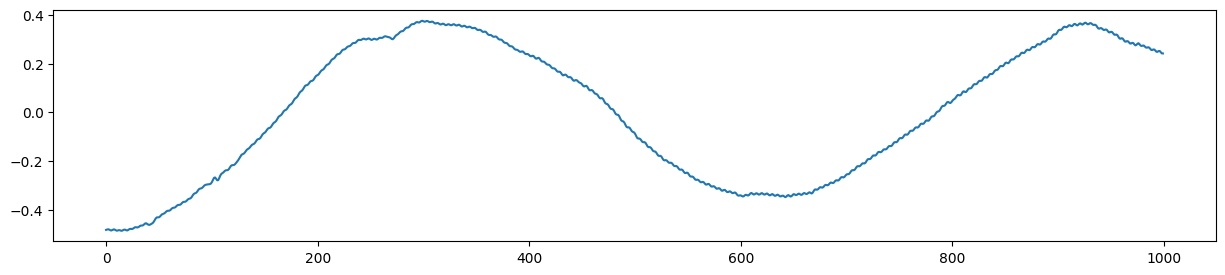

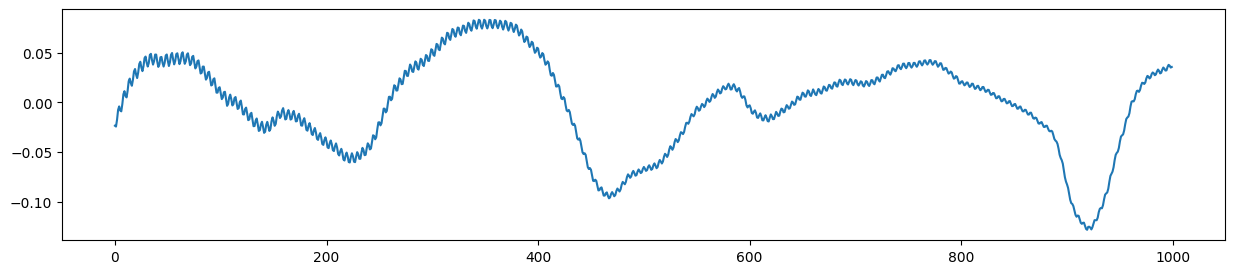

In [13]:
import ICA
data1 = [ICA.ica_pipeline(x,variance_threshold=2.0,kurtosis_threshold=3000) for x in data]
# data1 = [ICA.applyICA(x) for x in data[0:1]]


visualization.plotEEG(data[0][0][1000:2000],(15,3))
visualization.plotEEG(data1[0][0][1000:2000],(15,3))


In [67]:
data[0].shape[1]//600

203

In [160]:
signalLength = 300
step = 10

windowedSignals = []
windowedLabels = []
# # labels = []
for i in range(len(data)):
    # Iterate over each window in the signal
    for j in range(0, data[i].shape[1] - signalLength + 1, step):  # Adjust range
        if labels[i][j] == 'None':
            continue

        # Append the sliced signal data to windowedSignals
        windowedSignals.append(data[i][:, j:j + signalLength])  # Correct slicing

        # Append the corresponding label
        windowedLabels.append(labels[i][j])

# Print the shape of the first window to check



print(windowedSignals[0].shape)

(8, 300)


In [161]:
len(windowedSignals)

1788

In [162]:
windowedSignals[0].shape

(8, 300)

In [163]:
X = np.stack(windowedSignals)
print(X.shape)
y = np.stack(windowedLabels)
print(y.shape)



(1788, 8, 300)
(1788,)


In [4]:
np.unique(y,return_counts=True)

(array([0., 1.]), array([576855, 124760]))

In [ ]:
# Define the mapping dictionary
# label_mapping = {
#     'Comment/Down': 'Comment/Down',
#     'Comment/Left': 'Comment/Left',
#     'Comment/Right': 'Comment/Right',
#     'Comment/Up': 'Comment/Up',
#     'Comment/Select': 'Comment/Wait',
#     'Comment/Rest': 'Comment/Wait',
#     'Comment/Wait': 'Comment/Wait',
#     'Comment/WarmUp': 'Comment/Wait',
# }

label_mapping = {
    'Comment/Down': 'Activity',
    'Comment/Left': 'Activity',
    'Comment/Right': 'Activity',
    'Comment/Up': 'Activity',
    'Comment/Select': 'Comment/Wait',
    'Comment/Rest': 'Comment/Wait',
    'Comment/Wait': 'Comment/Wait',
    'Comment/WarmUp': 'Comment/Wait',
}

y_reduced = [label_mapping[label] for label in y]
print(np.unique(y_reduced,return_counts=True))
y = np.array(y_reduced)

(array(['Activity', 'Comment/Wait'], dtype='<U12'), array([ 337, 1451]))


In [5]:

# Assuming yVals is your labels array and xVals is your features array

# Find indices for each class by directly applying the condition to yVals
# stateA_indices = np.flatnonzero(y != 'Comment/Wait')
# stateB_indices = np.flatnonzero(y == 'Comment/Wait')

stateA_indices = np.flatnonzero(y != 0)
stateB_indices = np.flatnonzero(y == 0)





# Set the sample size to the number of StateA samples
sample_size = len(stateA_indices)

# Randomly sample from StateB indices to match the count of StateA
np.random.seed(42)  # For reproducibility
stateB_sampled_indices = np.random.choice(stateB_indices, size=sample_size, replace=False)

# Combine the sampled indices from StateB with all indices from StateA
balanced_indices = np.concatenate([stateA_indices, stateB_sampled_indices])

# Use the balanced indices to create the balanced feature and label arrays
X_balanced = X[balanced_indices]
y_balanced = y[balanced_indices]

# Optional: Shuffle the balanced arrays
shuffled_indices = np.random.permutation(len(y_balanced))
X_balanced = X_balanced[shuffled_indices]
y_balanced = y_balanced[shuffled_indices]

# xVals_balanced and yVals_balanced now contain balanced data for both classes


In [6]:
np.unique(y_balanced,return_counts=True)

(array([0., 1.]), array([124760, 124760]))

In [7]:
X = X_balanced
y = y_balanced

Now that we've applied ICA, we will use a standard architecture to evaluate the preprocessing methods

In [240]:
X[0].shape

(128, 8)

In [8]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)
Y = to_categorical(y_int)



In [10]:
X = X.transpose(0,2,1)
X.shape

(249520, 128, 8)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Watch validation loss
    patience=20,          # Stop after 5 epochs of no improvement
    restore_best_weights=True
)

In [36]:

model = Sequential()
# Add LSTM layer
# model.add(Conv1D(filters=64, kernel_size=64, strides=1, activation='relu', padding='same', input_shape=X[0].shape))
# model.add(Conv1D(filters=128, kernel_size=32, strides=1, activation='relu', padding='same'))
# model.add(Conv1D(filters=256, kernel_size=16, strides=1, activation='relu', padding='same'))
# model.add(Conv1D(filters=128, kernel_size=32, strides=1, activation='relu', padding='same'))
# model.add(Conv1D(filters=128, kernel_size=32, strides=1, activation='relu', padding='same'))
model.add(LSTM(units=128, return_sequences=True, input_shape = X[0].shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32, return_sequences=True))
model.add(LSTM(units=16, return_sequences=False))

# model.add(LSTM(units=4, return_sequences=False))

# Dense layers
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=Y.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 128, 128)       │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 128, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 128, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,322 (532.51 KB)

 Trainable params: 136,322 (532.51 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
randomVar = np.argmax(Y,axis=1)

np.unique(randomVar,return_counts=True)

(array([0, 1]), array([124760, 124760]))

In [37]:
history = model.fit(X,Y,epochs=100,batch_size=256,validation_split= 0.1,callbacks=[early_stopping])

Epoch 1/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - accuracy: 0.5080 - loss: 0.6933 - val_accuracy: 0.4973 - val_loss: 0.6934
Epoch 2/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.4996 - loss: 0.6933 - val_accuracy: 0.4972 - val_loss: 0.6932
Epoch 3/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.5033 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6931
Epoch 4/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.5008 - loss: 0.6931 - val_accuracy: 0.4971 - val_loss: 0.6942
Epoch 5/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.5007 - loss: 0.6934 - val_accuracy: 0.4971 - val_loss: 0.6934
Epoch 6/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.5001 - loss: 0.6934 - val_accuracy: 0.4971 - val_loss: 0.6941
Epoch 7/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.5044 - loss: 0.6934 - val_accuracy: 0.5327 - val_loss: 0.6908
Epoch 8/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.5128 - loss: 0

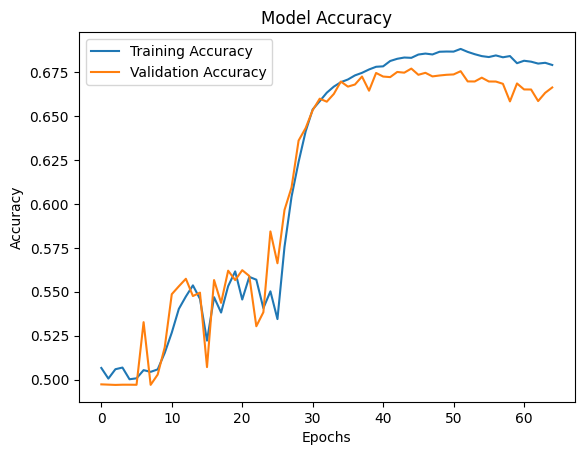

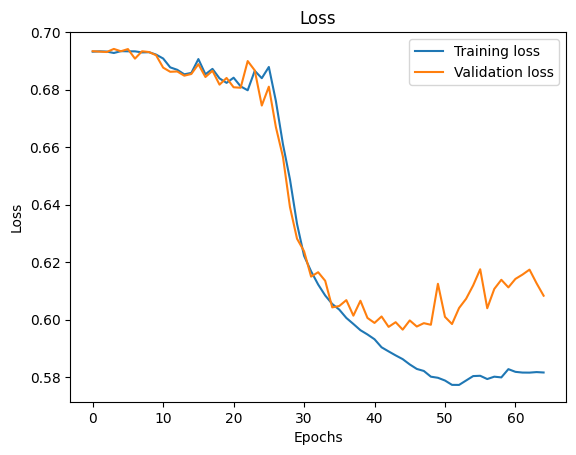

In [38]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Add labels and title

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

# Add legend
plt.legend()


# Show plot
plt.show()

plt.plot(history.history['loss'], label='Training loss')


plt.plot(history.history['val_loss'], label='Validation loss')

# Add labels and title

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')


# Add legend
plt.legend()


# Show plot
plt.show()




In [39]:
y_pred = np.argmax(model.predict(X),axis=1)
# Y_pred = np.argmax(y_pred,axis=1)

y_pred

7798/7798 ━━━━━━━━━━━━━━━━━━━━ 97s 12ms/step


array([0, 1, 0, ..., 0, 0, 1])

In [40]:
y_real = np.argmax(Y,axis=1)
y_real

array([1, 1, 0, ..., 1, 0, 1])

              precision    recall  f1-score   support

           0       0.76      0.66      0.71    142287
           1       0.62      0.72      0.66    107233

    accuracy                           0.69    249520
   macro avg       0.69      0.69      0.69    249520
weighted avg       0.70      0.69      0.69    249520



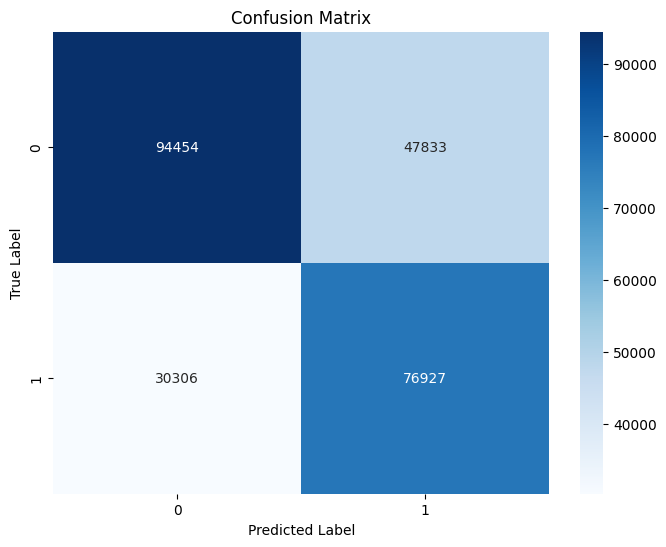

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_pred, y_real)
print(classification_report(y_pred, y_real))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()